In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
train = pd.read_csv('/content/gdrive/My Drive/fake news/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/fake news/test.csv')

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [22]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [24]:
train.drop(['author','title'], axis=1,inplace=True)
train.dropna(axis=0, subset=['text'], inplace=True)

test.drop(['author','title'], axis=1,inplace=True)
test.dropna(axis=0, subset=['text'], inplace=True)

In [7]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 79 kB/s 
     |████████████████████████████████| 6.8 MB 43.0 MB/s 
     |████████████████████████████████| 981 kB 44.4 MB/s 
     |████████████████████████████████| 263 kB 49.0 MB/s 
     |████████████████████████████████| 1.9 MB 42.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.7 MB/s 
     |████████████████████████████████| 468 kB 51.4 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
  Created wheel for ktrain: filename=ktrain-0.27.1-py3-none-any.whl size=25282876 sha256=c2e003fd20b5a0958e6b3da2882837842c8a44703a34c5d52eff7b9e2792248b
  Stored in directory: /root/.cache/pip/wheels/dd/88/9f/06a5d95fa827fda1af47f5c9eca78c6233928f0455171d3711
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=ef739c5b2fce19ccbdc78f5bebb7cc76039993eb300bcd9b78049e3dc46adadb
  Stored in directory: /root/.cache/pip/wheels/f5/ac/f1/4e13d7aff0

In [6]:
###Settings for gpu use###

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

In [5]:
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text

In [7]:
categories = ['Fake', 'True']

In [8]:
train["text"].isna().sum()

0

In [11]:
from sklearn.model_selection import train_test_split
X = train['text'].values
Y = train['label'].values

x_train, x_valid, y_train, y_valid = train_test_split(X,Y, test_size=0.2, random_state=9)

x_test = test['text'].values

In [12]:
model_name = "distilbert-base-uncased"
trans = text.Transformer(model_name, maxlen=512, class_names=categories)

In [13]:
train_data = trans.preprocess_train(x_train,y_train)
valid_data = trans.preprocess_test(x_valid,y_valid)

preprocessing train...
language: en
train sequence lengths:
	mean : 767
	95percentile : 1886
	99percentile : 4105


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 732
	95percentile : 1807
	99percentile : 3825


In [14]:
model = trans.get_classifier()

In [15]:
learner = ktrain.get_learner(model,train_data=train_data, val_data=valid_data, batch_size=16)
# here keep the batch_size as 16 only otherwise it will throw an error

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
1038/1038 [==============================] - 1006s 954ms/step - loss: 0.4025 - accuracy: 0.7894
Epoch 2/3
1038/1038 [==============================] - 409s 389ms/step - loss: 0.2867 - accuracy: 0.8258


done.
Visually inspect loss plot and select learning rate associated with falling loss


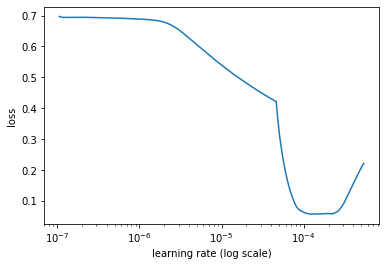

In [16]:
learner.lr_find(show_plot=True, max_epochs=3)

In [17]:
learner.fit_onecycle(lr=1e-4, epochs=2)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/2
1038/1038 [==============================] - 1100s 1s/step - loss: 0.0929 - accuracy: 0.9638 - val_loss: 0.0297 - val_accuracy: 0.9923
Epoch 2/2
1038/1038 [==============================] - 1102s 1s/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0097 - val_accuracy: 0.9981


In [18]:
learner.validate(class_names=categories)

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      2027
        True       1.00      1.00      1.00      2126

    accuracy                           1.00      4153
   macro avg       1.00      1.00      1.00      4153
weighted avg       1.00      1.00      1.00      4153



array([[2023,    4],
       [   4, 2122]])

In [19]:
learner.view_top_losses(n=5, preproc=trans)

----------
id:4112 | loss:8.85 | true:Fake | pred:True)

----------
id:2951 | loss:6.43 | true:True | pred:Fake)

----------
id:436 | loss:5.05 | true:True | pred:Fake)

----------
id:1199 | loss:2.43 | true:Fake | pred:True)

----------
id:480 | loss:2.36 | true:True | pred:Fake)



In [20]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [27]:
PRED = predictor.predict(x_test)

In [28]:
pred = pd.DataFrame(PRED)

In [29]:
pred = np.where(pred=='True',1,0)

In [33]:
test['label'] = pred

test.to_csv('submission.csv', columns=['id', 'label'], index=False)